# Machine Learning - Modeling (Part 1)

In [1]:
import pandas as pd
import numpy as np
import gc
from pycaret.classification import *

In [2]:
orders = pd.read_csv('./data/orders.csv')
prior_order = orders.query('eval_set == "prior"')
train_order = orders.query('eval_set == "train"')
test_order = orders.query('eval_set == "test"')

In [3]:
df = pd.read_csv('./data/df.csv')

In [4]:
df.head()

,user_id,product_id,last_purchase,reordered,lag,product_appear,buy_cnt,target
0,1,196,1.0,9.0,20.125,1.0,3.0,1
1,1,10258,1.0,8.0,20.125,0.9,3.0,1
2,1,10326,0.0,0.0,78.000,0.2,0.0,0
3,1,12427,1.0,9.0,20.125,1.0,3.0,0
4,1,13032,1.0,2.0,80.500,0.3,1.0,1


In [5]:
df = df.set_index(['user_id', 'product_id'])

#### Setup

In [6]:
exp = setup(df, target='target', categorical_features=['last_purchase'],
            train_size=.8)

 
Setup Succesfully Completed!


,Description,Value
0,session_id,1093
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(9030454, 6)"
4,Missing Values,False
5,Numeric Features,4
6,Categorical Features,1
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


#### Compare models

See if any models standout from the F1 score perspective

In [7]:
compare_models(blacklist=['knn', 'ridge', 'svm', 'lda', 'nb', 'qda', 'et', 'catboost'],
               fold=2, round=3, sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Extreme Gradient Boosting,0.915000,0.883000,0.506000,0.890000,0.645000,0.600000
1,Gradient Boosting Classifier,0.915000,0.883000,0.504000,0.893000,0.644000,0.600000
2,Ada Boost Classifier,0.914000,0.882000,0.505000,0.885000,0.643000,0.599000
3,Light Gradient Boosting Machine,0.915000,0.883000,0.503000,0.894000,0.643000,0.599000
4,Random Forest Classifier,0.901000,0.824000,0.519000,0.761000,0.617000,0.563000
5,Decision Tree Classifier,0.893000,0.745000,0.532000,0.698000,0.604000,0.544000
6,Logistic Regression,0.847000,0.747000,0.050000,0.527000,0.092000,0.067000


**Observation**: It turns major classification models have similar F1 score performance except Logistic Regression. Most models are able to have 0.5 "Recall", which mean out of all the true qualified reordered items, half of them are identified. Percision is at 0.89, which is pretty decent given no tuning has been made yet.
There could be room to increase the recall rate in order to maximize the F1 score (objective of the problem), assuming the trade off from precision will worth it. We will test will lower the binary cut off rate to 0.4 so see if improvement exist.

Base on the result above, we will test Light Gradient Boosting Machine (based on its speed of execution) and Gradient Boosting Classifier (has highest score in most metrics when comparing to others).

To save time, we will create the function below to automate the steps.

In [8]:

def model_f1(model, prob):
    """ Automate the step on generating models and prediction

    Args:
        model: the abbreviated string for estimators
        prob: probabiliy therhold to determin whether an output is 0 or 1

    Returns:
        name: created model
        var: prediction generated from the model
    """
    name = create_model(model, fold=2)
    var = predict_model(name, probability_threshold=prob)
    return name, var

**Light Gradient Boosting Machine**

In [9]:
%%time
lightgbm, lg_pred = model_f1('lightgbm', .4)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Light Gradient Boosting Machine,0.9123,0.8855,0.5519,0.8167,0.6587,0.6105


Wall time: 8.9 s


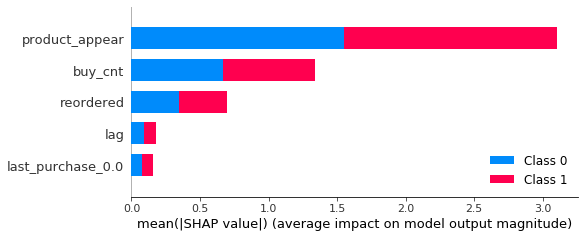

Wall time: 17.2 s


In [10]:
%%time
eval_lgbm = interpret_model(lightgbm)

**Gradient Boosting**

In [11]:
%%time
gbc, gbc_pred = model_f1('gbc', .4)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Gradient Boosting Classifier,0.9123,0.8857,0.5478,0.8205,0.657,0.609


Wall time: 47.4 s


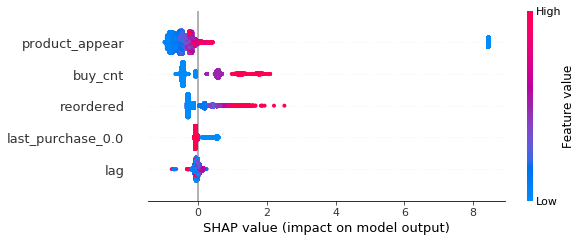

Wall time: 12.3 s


In [12]:
%%time
eval_gbc = interpret_model(gbc)

**Obseravtion**: The trade off appear to be equal among the increase in Recall but decrease in Precision. The net gain in F1 score is 0.01, not significant enough to justify the adjustment, at least from the training set data. However, the test set data are much smaller and that caes it may worth lower the probability in order minimize penalty from low recall.

### Save all the models for final test data submission

In [13]:
path = './data/save_model/'

def final_save(model, name):
    """ create the final model and save that as pkl file

    Args:
    model: model created with the sample data

    Returns:
    finalize model using all the data
    """

    final = finalize_model(model)
    save_model(final, model_name=path+name)

In [14]:
final_save(lightgbm, 'lgbm')
final_save(gbc, 'gbc')

Transformation Pipeline and Model Succesfully Saved


#### Kaggle Score (base model)

| Model | F1 |
|------| ----|
| Lightgbm | 0.35972 |
| Gradient Boost| 0.36244|

### Tune Model

After initial data submission, Gradient Boosting has higher F1 score on kaggle (0.362), with Lightgbm lag behind by 0.03 (0.359). We will tune the model to see if further improvement exist.

(Note on execution: Gradient Boosting tuning will take a long time. As we already know the base model performance from above. We executed the setup step to take only 5% of sample in order to get the tuned parameters)

In [15]:
light_tune = tune_model('lightgbm', fold=2, optimize='F1')
final_save(light_tune, 'lgbm_tune')

Transformation Pipeline and Model Succesfully Saved


In [ ]:
gbc_tune = tune_model('gbc', fold=2, optimize='F1')

IntProgress(value=0, description='Processing: ', max=8)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:20:26
Status,. . . . . . . . . . . . . . . . . .,Tuning Hyperparameters
ETC,. . . . . . . . . . . . . . . . . .,Calculating ETC


,Accuracy,AUC,Recall,Prec.,F1,Kappa


In [ ]:
final_save(gbc_tune, 'gbc_tune')

### Data Submission

Go to [data_sumbit]() workbook.